In [1]:
import rasterio
from pysheds.grid import Grid
import sys
from functions import *
from matplotlib import colors
import matplotlib.pyplot as plt
import geopandas as gpd

/sciclone/home/ntlewis/Nick-Lewis-Research/.conda/lib/python3.8/site-packages/lsdtopytools/geoconvtools.py:79: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @nb.jit(nopython = False)
/sciclone/home/ntlewis/Nick-Lewis-Research/.conda/lib/python3.8/site-packages/lsdtopytools/numba_tools.py:73: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @nb.jit(nopython=False,

In [31]:
get_topo(bounds=[39,-78,38.5,-78.5], name='small_test.tiff')

In [2]:
path = '/sciclone/home/ntlewis/Nick-Lewis-Research/working_files/data/small_test.tiff'
grid = Grid.from_raster(path)
dem = grid.read_raster(path)
print('read raster')

read raster


In [3]:
pit_filled_dem = grid.fill_pits(dem)
print('pits filled')

pits filled


In [4]:
flooded_dem = grid.fill_depressions(pit_filled_dem)
print('depressions filled')

depressions filled


In [5]:
inflated_dem = grid.resolve_flats(flooded_dem)
print('flats resolved')

flats resolved


In [6]:
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)
fdir = grid.flowdir(inflated_dem, dirmap=dirmap)
print(fdir.view())

[[ 1  1 -2 ... 16  1 -2]
 [ 1  1 64 ... 64 64 64]
 [ 1  1 64 ...  8  8 64]
 ...
 [ 2  2  1 ... 64 32 16]
 [ 2  4  4 ... 64 32 16]
 [ 1  1  1 ... 64 64 32]]


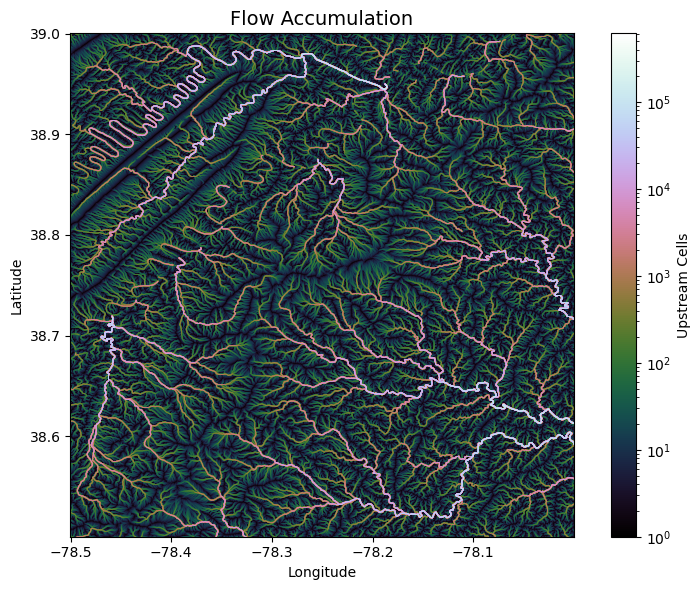

In [7]:
acc = grid.accumulation(fdir, dirmap=dirmap)
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(acc, extent=grid.extent, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, acc.max()),
               interpolation='bilinear')
plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title('Flow Accumulation', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

In [8]:
arr = np.array(acc.coords)
sub_arrays = np.split(arr, 1800, axis=0)
grid.shape[0]

1800

In [9]:
high_acc_coords = [sub_arrays[i][np.argsort(acc.view()[i])[-5:]] for i in range(len(sub_arrays))]
high_acc_values = [acc.view()[i][np.argsort(acc.view()[i])[-5:]] for i in range(len(sub_arrays))]
high_acc_values

[Raster([ 1052.,  1132.,  2124.,  2641., 19200.]),
 Raster([ 1123.,  1125.,  1881.,  2608., 19172.]),
 Raster([  994.,  1241.,  1769.,  2509., 19163.]),
 Raster([ 1350.,  1763.,  2508.,  6915., 12246.]),
 Raster([ 1338.,  1343.,  2507.,  6866., 12243.]),
 Raster([ 1327.,  2496.,  2504.,  6865., 12216.]),
 Raster([ 1295.,  6841.,  6848.,  6851., 12208.]),
 Raster([ 6809.,  6820.,  6831.,  6836., 12186.]),
 Raster([ 6523.,  6783.,  6792.,  6796., 12183.]),
 Raster([ 4322.,  4330.,  4454.,  6141., 12159.]),
 Raster([ 4462.,  6129.,  6135.,  6139., 12126.]),
 Raster([ 4481.,  6111.,  6117.,  6121., 12117.]),
 Raster([ 4728.,  4736.,  6100.,  6104., 12104.]),
 Raster([ 4838.,  4841.,  6070.,  6083., 10561.]),
 Raster([ 4805.,  4809.,  4814.,  4816., 10560.]),
 Raster([ 1532.,  2255.,  2282.,  4099., 10559.]),
 Raster([ 1527.,  2290.,  2292.,  4088., 10557.]),
 Raster([ 1362.,  1519.,  2301.,  4083., 10552.]),
 Raster([ 1693.,  2307.,  2318.,  4073., 10520.]),
 Raster([ 1494.,  1709.,  2334.

In [10]:
x = [x[i][1] for x in high_acc_coords for i in range(len(x))]
y = [x[i][0] for x in high_acc_coords for i in range(len(x))]
vals = np.array([x[i] for x in high_acc_values for i in range(len(x))]).reshape(-1,1)
gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(x,y), crs='EPSG:4326')
gdf['acc'] = vals
display(gdf)

,geometry,acc
0,POINT (-78.49972 39.00028),1052.0
1,POINT (-78.48611 39.00028),1132.0
2,POINT (-78.05917 39.00028),2124.0
3,POINT (-78.01611 39.00028),2641.0
4,POINT (-78.04722 39.00028),19200.0
...,...,...
8995,POINT (-78.35528 38.50056),35015.0
8996,POINT (-78.32667 38.50056),47413.0
8997,POINT (-78.32639 38.50056),47414.0
8998,POINT (-78.32611 38.50056),47415.0


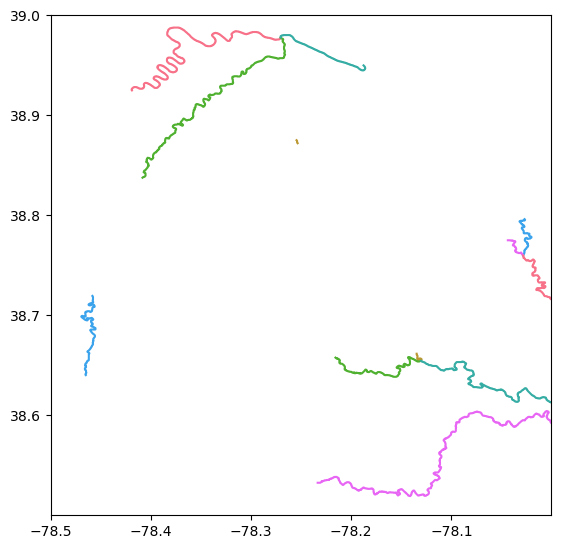

In [11]:
branches = grid.extract_river_network(fdir, acc > 100000, apply_output_mask=False)
sns.set_palette('husl')
fig, ax = plt.subplots(figsize=(8.5,6.5))
plt.xlim(grid.bbox[0], grid.bbox[2])
plt.ylim(grid.bbox[1], grid.bbox[3])
ax.set_aspect('equal')

for branch in branches['features']:
    line = np.asarray(branch['geometry']['coordinates'])
    plt.plot(line[:, 0], line[:, 1])

In [12]:
import json
geojson_string = json.dumps(branches, indent=2)
gdf_streams = gpd.read_file(geojson_string)

In [13]:
gdf_streams['stream_no'] = gdf_streams.index
gdf_streams


,geometry,stream_no
0,"LINESTRING (-78.41917 38.92472, -78.41944 38.9...",0
1,"LINESTRING (-78.25361 38.87194, -78.25389 38.8...",1
2,"LINESTRING (-78.40861 38.83750, -78.40833 38.8...",2
3,"LINESTRING (-78.27056 38.97750, -78.27056 38.9...",3
4,"LINESTRING (-78.02694 38.79611, -78.02667 38.7...",4
5,"LINESTRING (-78.04361 38.77500, -78.04333 38.7...",5
6,"LINESTRING (-78.02833 38.75972, -78.02805 38.7...",6
7,"LINESTRING (-78.13472 38.66167, -78.13472 38.6...",7
8,"LINESTRING (-78.21583 38.65778, -78.21555 38.6...",8
9,"LINESTRING (-78.13028 38.65444, -78.13000 38.6...",9


In [14]:
joined = gpd.sjoin_nearest(gdf, gdf_streams, how='left')
joined.drop(columns=['index_right'], inplace=True)
idx = joined.groupby(['stream_no'])['acc'].transform(max) == joined['acc']
pour_points_df = joined[idx]
pour_points_df

/sciclone/home/ntlewis/Nick-Lewis-Research/.conda/lib/python3.8/site-packages/geopandas/array.py:344: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


,geometry,acc,stream_no
413,POINT (-78.27055 38.97750),460986.0,2
418,POINT (-78.27055 38.97722),237178.0,0
914,POINT (-78.18778 38.94972),616736.0,3
2259,POINT (-78.25472 38.87500),145344.0,1
4328,POINT (-78.02833 38.76000),105456.0,5
4329,POINT (-78.02805 38.76000),135273.0,4
5059,POINT (-78.45861 38.71944),322602.0,10
5113,POINT (-78.00055 38.71639),286525.0,6
6228,POINT (-78.13055 38.65444),176285.0,8
6229,POINT (-78.13028 38.65444),313963.0,7


In [15]:
pour_points = [(point.x, point.y) for point in pour_points_df.geometry]
pour_points_df['tuples'] = pour_points
pour_points_df

/sciclone/home/ntlewis/Nick-Lewis-Research/.conda/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,geometry,acc,stream_no,tuples
413,POINT (-78.27055 38.97750),460986.0,2,"(-78.27055474172131, 38.97749963980598)"
418,POINT (-78.27055 38.97722),237178.0,0,"(-78.27055474172131, 38.97722186202598)"
914,POINT (-78.18778 38.94972),616736.0,3,"(-78.18777696328131, 38.949721861805976)"
2259,POINT (-78.25472 38.87500),145344.0,1,"(-78.2547214082613, 38.874999638985976)"
4328,POINT (-78.02833 38.76000),105456.0,5,"(-78.02833251756131, 38.75999963806598)"
4329,POINT (-78.02805 38.76000),135273.0,4,"(-78.0280547397813, 38.75999963806598)"
5059,POINT (-78.45861 38.71944),322602.0,10,"(-78.45861029878131, 38.71944408218597)"
5113,POINT (-78.00055 38.71639),286525.0,6,"(-78.00055473956131, 38.716388526605975)"
6228,POINT (-78.13055 38.65444),176285.0,8,"(-78.1305547406013, 38.65444408166597)"
6229,POINT (-78.13028 38.65444),313963.0,7,"(-78.1302769628213, 38.65444408166597)"


In [16]:
pour_points_x = [x[0] for x in pour_points_df.tuples]
pour_points_y = [x[1] for x in pour_points_df.tuples]

watersheds = []
for i in range(len(pour_points_x)):
    catch = grid.catchment(x=pour_points_x[i], y=pour_points_y[i], fdir=fdir, dirmap=dirmap, 
                       xytype='coordinate')
    watersheds.append(catch)
len(watersheds)

12

Text(0.5, 1.0, 'Delineated Catchment')

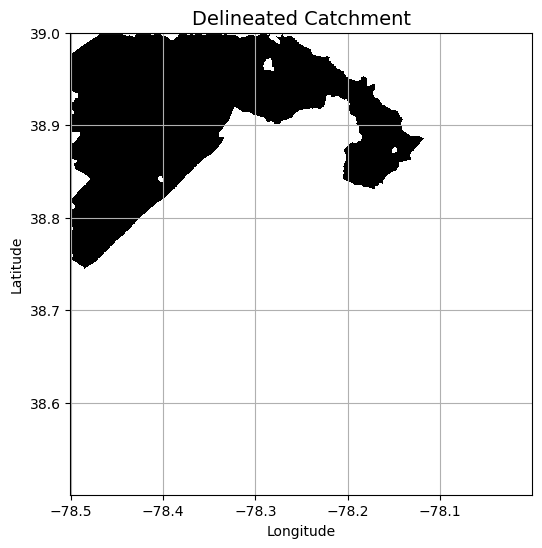

In [17]:
catch = watersheds[2]
clipped_catch = grid.view(catch)
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.grid('on', zorder=0)
im = ax.imshow(np.where(clipped_catch, clipped_catch, np.nan), extent=grid.extent,
               zorder=1, cmap='Greys_r')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Delineated Catchment', size=14)

In [18]:
src = rasterio.open('/sciclone/home/ntlewis/Nick-Lewis-Research/working_files/data/small_test.tiff')

In [19]:
from rasterio.plot import show
transform = src.transform
crs = src.crs
i=0
for watershed in watersheds:
    masked_data = np.where(watershed, src.read(1), np.nan)
    profile = {
    'driver': 'GTiff',
    'height': masked_data.shape[0],
    'width': masked_data.shape[1],
    'count': 1,  # Number of bands
    'dtype': masked_data.dtype,
    'crs': crs,
    'transform': transform,
    'compress': 'lzw' # Optional: Add compression
    }   
    output_path = f"/sciclone/home/ntlewis/Nick-Lewis-Research/working_files/data/watersheds/output_raster_{i}.tiff"
    with rasterio.open(output_path, 'w', **profile) as dst:
            dst.write(masked_data, 1)
    i+=1
